In [7]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import lcurve_corner as lc

from sklearn.preprocessing import PolynomialFeatures

from scipy.linalg import lstsq
from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

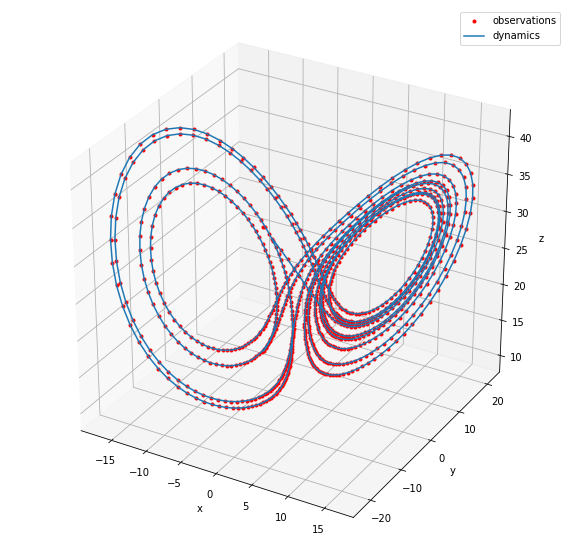

In [8]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def lorenz63(x, t, sigma=10, rho=28, beta=8/3):
    return [
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    ]

sig=10
rho=28
beta=8/3


####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 3 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [-8, 7, 27]
X = odeint(lorenz63, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]
x3 = X[:,2]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = sig * (x2 - x1)
dX[:,1] =  x1 * (rho - x3) - x2
dX[:,2] = x1 * x2 - beta * x3

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.01
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
dY = dX + sigma * np.random.randn(n_times,n_states)# Remove this line 

t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]
y3 = Y[:,2]

#Plot dynamical system and observations
plt.figure(figsize = (10,10))
ax = plt.axes(projection="3d")
ax.plot3D(y1,y2,y3,'r.')
ax.plot3D(x1[1:],x2[1:],x3[1:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(['observations','dynamics'])
plt.show()

In [9]:
# SET UP LINEAR ALGEBRA PROBLEM

#Model to approximate functions f1 = dx1 and f2 = dx2
poly_d = 3
poly = PolynomialFeatures(poly_d)
Phi = poly.fit_transform(Y)
basis_names = poly.get_feature_names()
p_basis = Phi.shape[1]#Number of basis functions

#Normalize columns of X
c_norm = np.linalg.norm(Phi, axis=0)
Wn = np.diag(1 / c_norm)
Phin = np.dot(Phi, Wn)#column-normalized X

In [10]:
# SOLVE UNWEIGHTED BPDN 
Beta = np.zeros((p_basis, n_states))

for state in range(n_states):
    
    dy = dY[:,state]
    beta = lc.lcurve_corner(Phi, dy, lambda_min = 1e-16, lambda_max = 1, epsilon = 0.001, max_iter = 50)
    Beta[:,state] = beta

/home/alexandre/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


  Convergence criterion reached in 14 iterations.
  Convergence criterion reached in 13 iterations.
  Convergence criterion reached in 12 iterations.


In [11]:
Beta[np.abs(Beta) < 0.1] = 0
Beta

array([[ 0.        ,  0.13759588,  0.        ],
       [-9.99318309, 27.9720739 ,  0.        ],
       [ 9.99429801, -0.96738689,  0.        ],
       [ 0.        ,  0.        , -2.65316508],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99880142],
       [ 0.        , -0.99667512,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [12]:
# SOLVE WEIGHTED BPDN 
num_itr = 3
q = 2
eps_w = 0.0001

for state in range(n_states): 
    
    print(f'Solving for state variable x{state+1}.')
    dy = dY[:,state]
    
    for itr in range(num_itr):
        
        print(f'  Weighted iteration {itr}.')

        #Apply weighting
        w = 1 / (np.abs(Beta[:,state]) ** 2 + eps_w)
        Ww = np.diag(1 / w)
        Phiw = np.dot(Phi, Ww)

        beta_w = lc.lcurve_corner(Phiw, dy, lambda_min = 1e-16, lambda_max = 1, epsilon = 0.001, max_iter = 50)
        Beta[:,state] = np.dot(Ww, beta_w)
        
    print('\n')
    


Solving for state variable x1.
  Weighted iteration 0.
  Convergence criterion reached in 9 iterations.
  Weighted iteration 1.
  Convergence criterion reached in 13 iterations.
  Weighted iteration 2.
  Convergence criterion reached in 8 iterations.


Solving for state variable x2.
  Weighted iteration 0.
  Convergence criterion reached in 11 iterations.
  Weighted iteration 1.
  Convergence criterion reached in 10 iterations.
  Weighted iteration 2.
  Convergence criterion reached in 9 iterations.


Solving for state variable x3.
  Weighted iteration 0.
  Convergence criterion reached in 11 iterations.
  Weighted iteration 1.
  Convergence criterion reached in 9 iterations.
  Weighted iteration 2.
  Convergence criterion reached in 8 iterations.




In [13]:
Beta[np.abs(Beta) < 0.1] = 0
Beta

array([[ 0.        ,  0.13759588,  0.        ],
       [-9.99291045, 27.9720739 ,  0.        ],
       [ 9.99416659, -0.96738689,  0.        ],
       [ 0.        ,  0.        , -2.65316508],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99880142],
       [ 0.        , -0.99667512,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])